# X-ray spectrum 

First we will look at X-ray spectra generated from conventional tubes used in clinical practice. In the following you can see the schematic of a conventional X-ray tube.
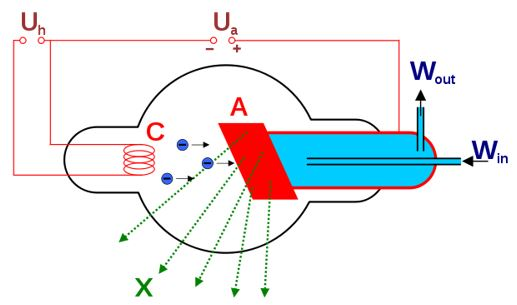
What are the important parameters?

(2, 151)


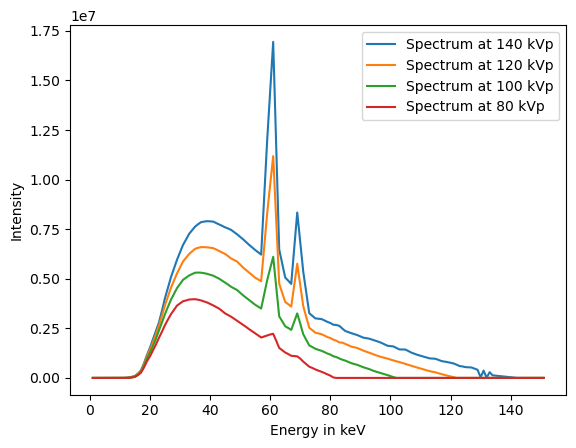

In [45]:
# We can open our figures in interactive mode
#%matplotlib notebook
# or as images
%matplotlib inline

from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt
import scipy
import xraylib
# from pathlib import Path # Path('/etc')

base_path = 'spectrum_data/'

#define a function do load the spectra
def load_spectrum(kVp):
    '''This function can be used to load tungsten X-ray spectra ranging from 35kVp to 150kVp'''
    #data = np.loadtxt(base_path + 'W_'  + str(kVp) + 'kVp.txt', delimiter = ',')
    data = np.loadtxt("spectrum_data/W_{0}kVp.txt".format(kVp), delimiter = ',') # We load certain txt with the form "W_xkVp.txt" in the folder "spectrum_data"...
    #... whose first row is the energy of X-ray spectrum at a voltage x kVp and the second row is the intensity of the spectrum. With the...
    #...option "delimiter=," we are telling python that all my data is separated by comas in the .txt file that we are loading.
    return data

print(load_spectrum(90).shape)

energy_90, intensity_90 = load_spectrum(90)[0,:], load_spectrum(90)[1,:] # The first row of the spectrum data is the energy. The second row is the intensity
energy_80, intensity_80 = load_spectrum(80)
energy_100, intensity_100 = load_spectrum(100)
energy_120, intensity_120 = load_spectrum(120)
energy_140, intensity_140 = load_spectrum(140)

plt.figure()
#plt.title('Tungsten anode X-ray spectra')
plt.plot(energy_140, intensity_140, label="Spectrum at 140 kVp")
plt.plot(energy_120, intensity_120, label="Spectrum at 120 kVp")
plt.plot(energy_100, intensity_100, label="Spectrum at 100 kVp")
plt.plot(energy_80, intensity_80, label="Spectrum at 80 kVp")
plt.legend() # This makes the label box to appear
plt.xlabel('Energy in keV')
plt.ylabel('Intensity')
plt.savefig('report_figures/01_spectra.pdf',bbox_inches='tight')
plt.show()

We can generate two spectrally seperated measurements by introducing a filter.

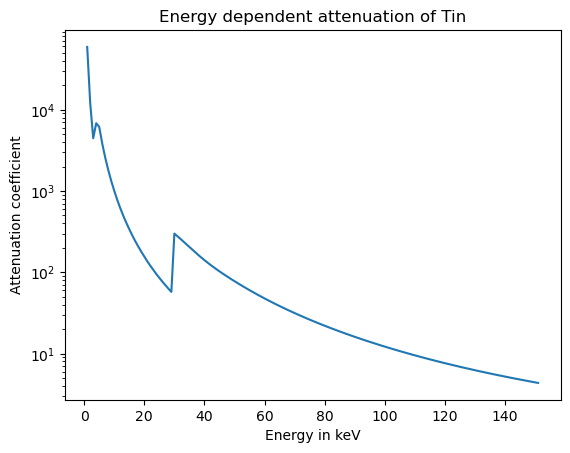

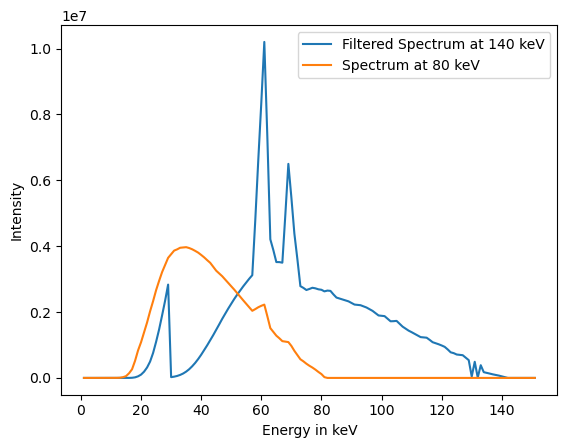

The two medical spectra have an overlap of 31.2 %.


In [46]:
def get_absorption_coeffcient(compound, density, energy):
    energies = energy
    mues = np.empty_like(energies)
    for i, energy in enumerate(energies):
        mues[i] = xraylib.CS_Total_CP(compound, energy) # cm^2/g # xraylib library have the information of mass attenuation coefficient of certain...
        #...compound at certain energies. Here we save all the values of mu/rho for each of the energies inside the array "energy" for the ...
        #...compound called "compound"
    mue_rho = mues * density # 1/cm # We define de linear attenuation coefficient from the mass attenuation coefficient
    return mue_rho


mu_rho = get_absorption_coeffcient('Sn', 7.265, energy_140) # Tin (Zinn) with a density of 7.265 g/cm^3 # We obtain mu/rho for Tin for the energies in array "energy_140"
filter_thickness = 0.02 # in cm

plt.figure() # We plot mu of tin vs energies (energies inside the array "energy_140")
plt.title('Energy dependent attenuation of Tin')
plt.plot(energy_140, mu_rho)
plt.xlabel('Energy in keV')
plt.ylabel('Attenuation coefficient')
plt.yscale('log')
plt.show()

# we can increase the heating voltage for more electrons -> higher intensity in X-ray photons
intensity_140_highcurrent = intensity_140 * 1.5 # We artificially increase the intensity of the spectrum (due to increase in heating voltage)...
#...by multiply the original intensity of the spectrum at 140 keV by a factor of 1.5
intensity_140_highcurrent_filtered = intensity_140_highcurrent * np.exp(-mu_rho*filter_thickness) # insert Beer–Lambert law # We simulate that...
#...spectra passed through a Tin filter with thickness = 0.02 cm 
# We filtrate 140 keV spectrum such that the overlap between these spectrum and the spectrum at 80 keV are not so much overlapped.

plt.figure()
#plt.title('Comparison of two spectra')
plt.plot(energy_140, intensity_140_highcurrent_filtered, label="Filtered Spectrum at 140 keV") 
plt.plot(energy_80, intensity_80, label="Spectrum at 80 keV")
plt.legend()
plt.xlabel('Energy in keV')
plt.ylabel('Intensity')
plt.savefig('report_figures/02_dual_source_spectra_separated.pdf',bbox_inches='tight')
plt.show()

# Spectral overlap
intensity_integral_80 = np.sum(intensity_80)
intensity_integral_140_highcurrent_filtered = np.sum(intensity_140_highcurrent_filtered)
# the spectra cross at 56.5 keV -> energy_140[48] = energy_80[48]
overlap_integral = np.sum(intensity_140_highcurrent_filtered[:48]) + np.sum(intensity_80[48:]) # [:48] = [0, 48], [48:] = [48, -1]
overlap_percentage = 100 * overlap_integral / (intensity_integral_80 + intensity_integral_140_highcurrent_filtered - 2 * overlap_integral)

print('The two medical spectra have an overlap of {overlap} %.'.format(overlap=overlap_percentage.round(2)))

Another possibility to measure energy dependent information in CT can be achieved by the design of an energy responsive detector. Here is a schematic of a dual scintillator layer design:  
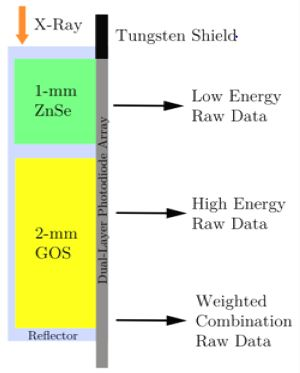  
In the following we want to determine the theoretical detector response function of this Dual-Layer (DL) detector.

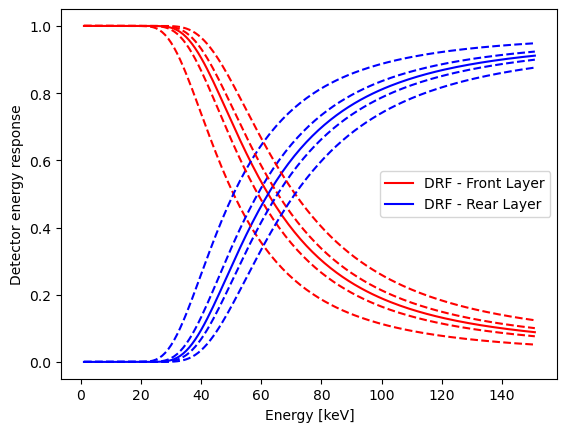

In [47]:
mu_znse = get_absorption_coeffcient('ZnSe', 5.27, energy_120) # ZnSe Scintillator layer attenuation coefficient
layer_thickness_f = 0.07 # cm

det_response_f = 1-np.exp(-layer_thickness_f*mu_znse) # scintillator attenuation in front layer -> detector response. # We define the...
#detector response function for the ZnSe layer as follows: from the 100% of photons (100% = 1), the layer let pass "np.exp(-layer_thickness_f*mu_znse)"...
#photons according to beer-labert law. So the percentage (in range 0 to 1) of photons absorbed by the detector is 1-np.exp(-layer_thickness_f*mu_znse
det_response_r = 1 - det_response_f # rear layer -> all remaining photons get absorbed 
# percentage of photons absorbed by two layers must be 100% = 1 -> det_response_f + det_response_r = 1 -> det_response_r = 1 - det_response_f

energy = energy_120 # we will focus on a medical spectrum with 120 kVp
intensity = intensity_120
plt.figure('Detector energy response function for DLCT')
plt.plot(energy, det_response_f,color="red", linestyle="-", label='DRF - Front Layer')
plt.plot(energy, det_response_r, color="blue", linestyle="-", label='DRF - Rear Layer')
# we will look at different front layer thickness designs
layer_thickness_var = np.array([0.04, 0.06, 0.08, 0.1]) # Different values for front layer thickness

for thickness in layer_thickness_var:
    det_res_f = (1-np.exp(-thickness*mu_znse)) # We plot detector response functions for different front detector layer thicknesses
    det_res_r = (np.exp(-thickness*mu_znse))
    plt.plot(energy, det_res_f, color="red", linestyle="--")
    plt.plot(energy, det_res_r, color="blue", linestyle="--")
plt.xlabel('Energy [keV]')
plt.ylabel('Detector energy response')# (0.4, 0.6, 0.7, 0.8, 1.0) mm ZnSe')
plt.legend()
plt.savefig('report_figures/03_dl_detector_response.pdf',bbox_inches='tight')
plt.show(block=False)

Let´s check the spectral overlay for the design of a 0.7 mm thick front layer.

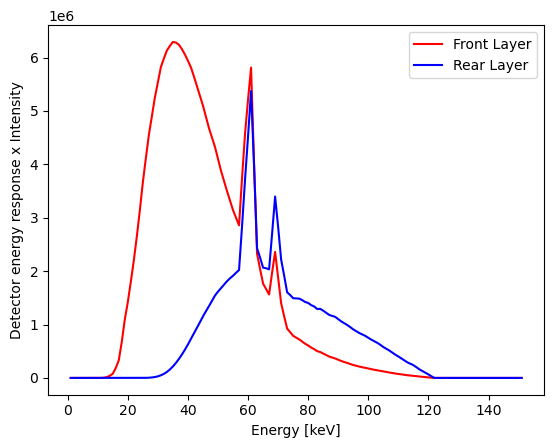

The spectral overlap in this DL design is 50.6 %.


In [48]:
plt.figure('Effective spectra in energy discriminating detector')
plt.plot(energy_120,intensity_120*det_response_f,color="red", linestyle="-",label='Front Layer') # Intensity_120*det_response_f is the intensity...
#...of the spectrum at 120 keV measured by the front layer detector
plt.plot(energy_120,intensity_120*det_response_r,color="blue", linestyle="-",label='Rear Layer')# Intensity_120*det_response_r is the intensity...
#...of the spectrum at 120 keV measured by the rear layer detector
plt.xlabel('Energy [keV]')
plt.ylabel('Detector energy response x Intensity')
plt.legend()
plt.savefig('report_figures/04_dual_layer_spectra_separated.pdf',bbox_inches='tight')
plt.show(block=False)

# Spectral overlap
intensity_integral_f = np.sum(intensity*det_response_f)
intensity_integral_r = np.sum(intensity*det_response_r)
# the spectra cross at 62.3 keV -> energy[54]
overlap_integral = np.sum((intensity*det_response_r)[:54]) + np.sum((intensity*det_response_f)[54:])
overlap_percentage = 100 * overlap_integral / (intensity_integral_f + intensity_integral_r - 2 * overlap_integral)

print('The spectral overlap in this DL design is {overlap} %.'.format(overlap=overlap_percentage.round(2))) # They found the overlapping...
#...between the spectrum measured by the front layer detector with the spectrum measured by the rear layer detector

## Phantom design

We will introduce an artificial phantom to simulate spectral measurements. The phantom will contain water, bone (Hydroxyapatite) and iodine. Hydroxyapatite, also called hydroxylapatite (HA), is a naturally occurring mineral form of calcium apatite with the formula Ca5(PO4)3(OH). Iodine is used as a contrast agent for clinical CT examinations. Intravenously infused it gives good contrast in blood vessels (aorta, coronary vessels -> e.g. diagnosing cardiac infarction)

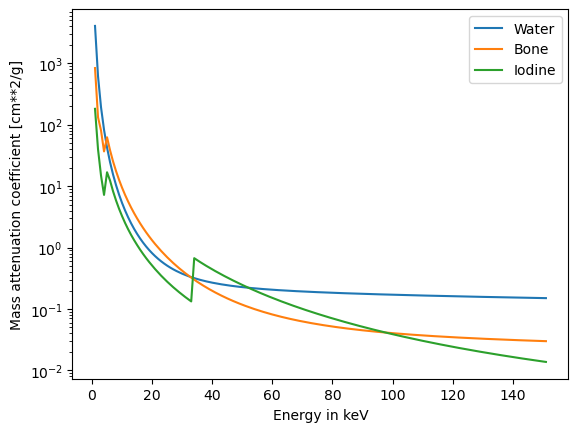

In [49]:
# Plot the attenuation coefficient for water, HA and iodine
mu_rho_water = get_absorption_coeffcient('H2O', 1.0, energy)
mu_water = mu_rho_water/1.0 # mass attenuation coefficient (mu_rho/rho)
mu_rho_HA = get_absorption_coeffcient('Ca5P3O13H', 0.2, energy) # Bone with a bone mineral density of 0.2 g/cm^3
mu_HA = mu_rho_HA/0.2
mu_rho_I = get_absorption_coeffcient('I', 0.02, energy) # Iodine contrast with 20 mg/ml
mu_I = mu_rho_I/0.02

plt.figure()
#plt.title('Attenuation of water, bone and iodine')
plt.plot(energy, mu_rho_water, label = 'Water')
plt.plot(energy, mu_rho_HA, label = 'Bone')
plt.plot(energy, mu_rho_I, label = 'Iodine')
plt.xlabel('Energy in keV')
plt.ylabel('Mass attenuation coefficient [cm**2/g]')
plt.yscale('log')
plt.legend()
plt.savefig('report_figures/05_energy_dep_mass_att_coef.pdf',bbox_inches='tight')
plt.show()

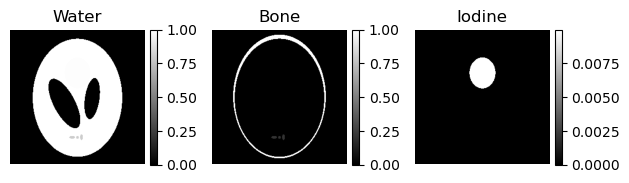

In [50]:
# Load the phantom.
water = np.load('phantom/water.npy') # We load three external .npy files, which are matrices (images)
bone = np.load('phantom/bone.npy')
iod = np.load('phantom/iod.npy')


# show density maps [g/cm^3]
fig, axs = plt.subplots(1, 3) # We obtain a set of 1x3 (rows x columns) images
pcm1 = axs[0].imshow(water, cmap='gray') #axs[0] is the first plot. axs[1] is the second plot and so on
fig.colorbar(pcm1, ax=axs[0], fraction=0.046, pad=0.04)
axs[0].axis('off') # "Turn-off" axes
axs[0].title.set_text('Water') # Title of the sub-figure
pcm2 = axs[1].imshow(bone, cmap='gray')
fig.colorbar(pcm2, ax=axs[1], fraction=0.046, pad=0.04)
axs[1].axis('off')
axs[1].title.set_text('Bone')
pcm3 = axs[2].imshow(iod, cmap='gray')
fig.colorbar(pcm3, ax=axs[2], fraction=0.046, pad=0.04)
axs[2].axis('off')
axs[2].title.set_text('Iodine')
fig.tight_layout()
plt.savefig('report_figures/06_phantom.pdf',bbox_inches='tight')
plt.show()

Now we can create so called virtual monoenergetic images (VMI or MonoE) of our phantom.

In [51]:
# MonoE @ 70 keV simulates images close to conventional CT images
print(energy_120[69], 'keV') # Print the 69 component of the array called "energy = energy_120". This component is equal to 70 keV

monoE_70 = mu_water[69]*water + mu_HA[69]*bone + mu_I[69]*iod # mass attenuation coefficient * density [g/cm^3] # We multiply water phantom...
#...(with no physical units) by the mu/rho of water at 70 keV, such that the phantom now represents a distribution of mu/rho of water in the...
#...phantom. The same is done with bone and iodine phantoms and then we add them all to obtain a phantom which includes info about mu/rho...
#...distribution of water, bone and iodine at only 70 keV

70.0 keV


Normally CT images are displayed in HU units: $ HU = 1000 \cdot \dfrac{\mu-\mu_{water}}{\mu_{water}-\mu_{air}} $ with the absoption coefficient $ \mu $. We assume the attenuation coefficient of air to be zero.

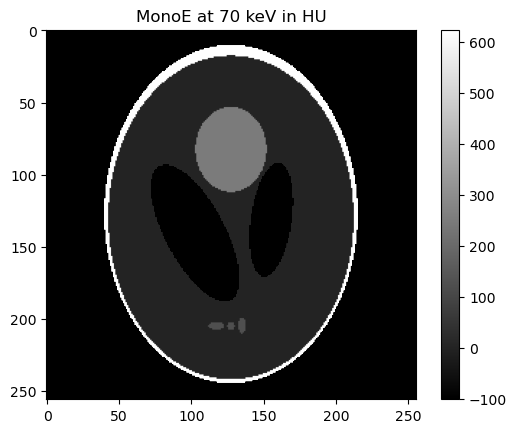

In [52]:
HU_70 = 1000*(monoE_70 - mu_water[69])/(mu_water[69] - 0)

plt.figure()
plt.title('MonoE at 70 keV in HU')
plt.imshow(HU_70, cmap='gray', vmin = -100)
plt.colorbar()
plt.show()

## Dual Layer CT (DLCT)
So let´s simulate what we can measure in a Dual Layer CT (DLCT) system.


 Water
Simulating: 018/1000

Simulating: 1000/1000
 Bone
Simulating: 1000/1000
 Iodine
Simulating: 1000/1000

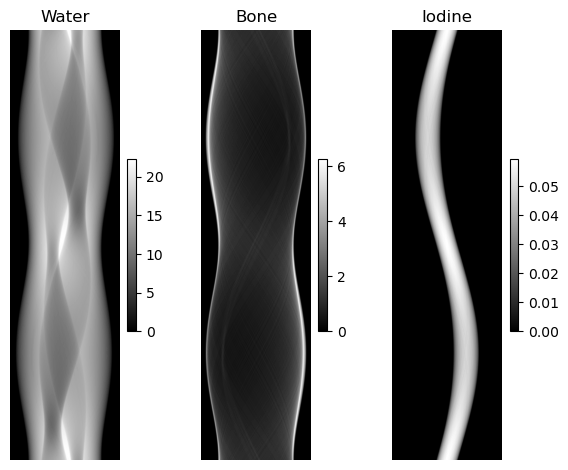

In [53]:
# We import some functionality for our simple CT simulation
from reco import get_mask, forwardproject, filter_ramlak, backproject, art # reco refers to reco.py, which include the functions that we are...
#...exporting in this line of code

# Define the vector containing the projection angles. They were sampled 
# equidistantly over a 360 degree rotation.
nproj = 1000 # number of projections
angles = np.linspace(0, 360., nproj, False)

pixel_size = 0.1 # cm

print('\n Water')
proj_water = forwardproject(water, angles) * pixel_size # Sinogram of forward projected water densities
print('\n Bone')
proj_bone = forwardproject(bone, angles) * pixel_size # Sinogram of forward projected bone densities (areal bone mineral density aBMD)
print('\n Iodine')
proj_iod = forwardproject(iod, angles) * pixel_size # Sinogram of forward projected iodine densities (areal bone mineral density aBMD)

fig, axs = plt.subplots(1, 3)
pcm1 = axs[0].imshow(proj_water, cmap='gray')
fig.colorbar(pcm1, ax=axs[0], fraction=0.046, pad=0.04)
axs[0].axis('off')
axs[0].title.set_text('Water')
pcm2 = axs[1].imshow(proj_bone, cmap='gray')
fig.colorbar(pcm2, ax=axs[1], fraction=0.046, pad=0.04)
axs[1].axis('off')
axs[1].title.set_text('Bone')
pcm3 = axs[2].imshow(proj_iod, cmap='gray')
fig.colorbar(pcm3, ax=axs[2], fraction=0.046, pad=0.04)
axs[2].axis('off')
axs[2].title.set_text('Iodine')
fig.tight_layout()
plt.savefig('report_figures/07_areal_densities_GT.pdf',bbox_inches='tight')
plt.show()

In the following we want to simulate the intensity measured in our front and rear detector layer. For this we want to assume, that the number of initial photons is evenly distributed along the detector array. Also we integrate over all arriving X-ray photons times their energy (we integrate the spectrum), which gives us a signal direct proprtional to the number of arriving visible light photons at the photodiode (pixel).

In [54]:
detector_pixel_lenght = proj_water.shape[1] # Number of columns of the sinogram for water
nproj = proj_water.shape[0] # Number of rows of the sinogram for water

# full spectrum flatfield on every detector pixel
i_0_pix = (intensity_120/detector_pixel_lenght).astype(int) # We divide the spectrum by the number of pixels of our "1D detector" array. This is
#supposed to symbolize somehow the number of photons which arrives at each detector pixel. This is the reason why we convert this quantity
# into an integer number, since the number of photons per pixel muest be an entire number 
# photons only appear as natural numbers

# flatfield x-ray photons in scintillator layer 1 and 2
flat_front = (intensity_120*det_res_f).astype(int) # Intensity (number of photons) that arrives at the front layer detector (without sample)
flat_rear = (intensity_120*det_res_r).astype(int) # Intensity (number of photons) that arrives at the rear layer detector (without sample)

# integrated visible light photons at photodiodes after sample
i_a_front_integrated = np.zeros_like(proj_water) # We create an array of zeros with the same size of "proj_water" (sinogram of water phantom)
i_a_rear_integrated = np.zeros_like(proj_water) # We create an array of zeros with the same size of "proj_water" (sinogram of water phantom)

for proj in np.arange(nproj):
    for pix in np.arange(detector_pixel_lenght):
        # calculating the spectral attenuation of our sample in every detector pixel at every angle
        exponent = -mu_water*proj_water[proj,pix]-mu_HA*proj_bone[proj,pix]-mu_I*proj_iod[proj,pix]
        # we simulate the measured signal as the integration over all photon counts times energy
        # this can be jutsified with an scintillator behavior which is direct proportional to the energy of
        # the incoming x-ray photons
        i_a_front_integrated[proj,pix] = np.sum(flat_front * energy * np.exp(exponent)).astype(np.uint32) # Here the equation (12) of...
        #...the DECT manual is used. This equation tells that the intensity measure at certain point is...
        # I = integral(I_0*Det_res_func*e^(-mu_1x_1 - mu_2x_2 - ...)dE). The integral is done with the function np.sum(). uint32 means integer

        i_a_rear_integrated[proj,pix] = np.sum(flat_rear * energy * np.exp(exponent)).astype(np.uint32)
        # actually the measured signal is dependend on the photodiode and the analog to digital converter
        # for the moment we ignore this

We have several noise adding components in our simulation framework.
For the case of normal clinical exposures, the X-ray CT measurements are often modeled as the sum of a Poisson distribution representing photon-counting statistics and an independent Gaussian distribution representing additive electronic noise. We assume a simple gaussian noise distribution in our simulation.

In [55]:
sigma = 5e-5 * i_a_front_integrated.max() # standard deviation set to 0.05 per mille -> approx. 1e5

In [56]:
mu = 0 # mean

i_a_front_integrated_noisy = i_a_front_integrated + np.random.normal(mu, sigma, np.shape(i_a_front_integrated)) # Add gaussian (normal) noise (random numbers) to our previous results
i_a_rear_integrated_noisy = i_a_rear_integrated + np.random.normal(mu, sigma, np.shape(i_a_rear_integrated))

Now we want to take a look at our line integrals:

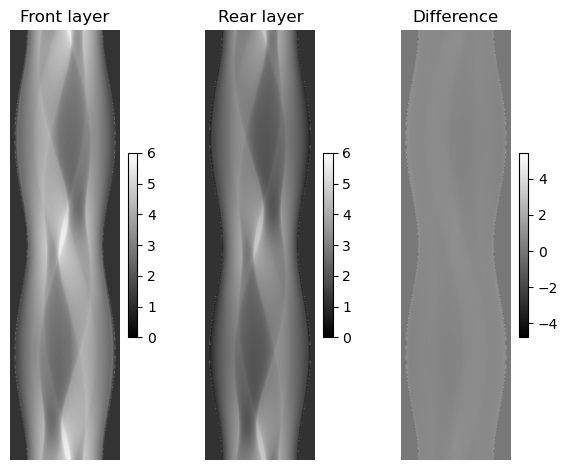

In [57]:
i_a_front_integrated_noisy.clip(min = 1) # zero counts to one for log
i_a_rear_integrated_noisy.clip(min = 1) # zero counts to one for log

lineintegral_front = -np.log(i_a_front_integrated_noisy/np.sum(flat_front * energy)) # Line integral is defined as -ln(I/I_0), where I and 
#I_0 are given by equation (12) of the DECT manual, as previously stated
lineintegral_rear = -np.log(i_a_rear_integrated_noisy/np.sum(flat_rear * energy))

#lineintegral_front and lineintegral_rear are basically the sinograms obtained from the information given by both detectors

# plot simulated line integrals
fig, axs = plt.subplots(1, 3)
pcm1 = axs[0].imshow(lineintegral_front, cmap='gray', vmin=0, vmax=6)
fig.colorbar(pcm1, ax=axs[0], fraction=0.046, pad=0.04)
axs[0].axis('off')
axs[0].title.set_text('Front layer')
pcm2 = axs[1].imshow(lineintegral_rear, cmap='gray', vmin=0, vmax=6)
fig.colorbar(pcm2, ax=axs[1], fraction=0.046, pad=0.04)
axs[1].axis('off')
axs[1].title.set_text('Rear layer')
pcm2 = axs[2].imshow(lineintegral_front-lineintegral_rear, cmap='gray')
fig.colorbar(pcm2, ax=axs[2], fraction=0.046, pad=0.04)
axs[2].axis('off')
axs[2].title.set_text('Difference') # When we look at the difference between the sinograms, we can see that the sinogram for ionide-only image appear somehow!
fig.tight_layout()
plt.savefig('report_figures/08_DLCT_measuremed_data.pdf',bbox_inches='tight')
plt.show()

## Basis Material Decomposition
We want to retrieve the material densities in projection space. As we have only two independent measurements we can only calculate areal densities for two materials. We will choose water and bone (hydroxylapatide). All other materials (like iodine in our case) will be displayed as a linear combination of those two materials.

In [58]:
from scipy.optimize import least_squares

def BeerLambert(x):
    exponent = -mu_water*x[0]-mu_HA*x[1]
    return np.array([np.sum(flat_front*energy*np.exp(exponent)), np.sum(flat_rear*energy*np.exp(exponent))])

# default guess
x0 = np.array([0, 0])

# we will use these arrays to save our estimates
proj_water_estimate = np.zeros_like(lineintegral_front)
proj_bone_estimate = np.zeros_like(lineintegral_front)

# if you want to load results set variable False
calculate_here = False

if calculate_here:
    # we have to go through every pixel
    # ATTENTION: This is a highly NOT optimized way to calculate our material projection images
    for proj in np.arange(nproj):
        if proj%10 == 0: print(100*proj/nproj, ' % done')
        for pix in np.arange(detector_pixel_lenght):
            # check out our measurement of the current pixel
            measurement = [i_a_front_integrated_noisy[proj,pix], i_a_rear_integrated_noisy[proj,pix]]
            # we want to minimize the difference between forward model (BeerLambert) and measurement
            def fun(x):
                return BeerLambert(x) - measurement
            # write current estimate in designated arrays
            water_pix, bone_pix = least_squares(fun, x0).x        
            proj_water_estimate[proj, pix] = water_pix
            proj_bone_estimate[proj, pix] = bone_pix

Save/load estimates

In [59]:
if calculate_here:
    np.save('proj_water_estimate_tmp.npy',proj_water_estimate)
    np.save('proj_bone_estimate_tmp.npy', proj_bone_estimate)
else:
    proj_water_estimate = np.load('intermed_results/proj_water_estimate.npy')
    proj_bone_estimate = np.load('intermed_results/proj_bone_estimate.npy')

Let´s look at our optimization results.

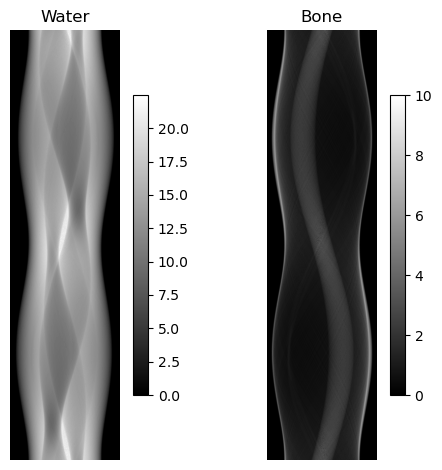

In [60]:
fig, axs = plt.subplots(1, 2)
pcm1 = axs[0].imshow(proj_water_estimate, cmap='gray', vmin=0)
fig.colorbar(pcm1, ax=axs[0], fraction=0.046, pad=0.04)
axs[0].axis('off')
axs[0].title.set_text('Water')
pcm2 = axs[1].imshow(proj_bone_estimate, cmap='gray', vmin=0, vmax=10)
fig.colorbar(pcm2, ax=axs[1], fraction=0.046, pad=0.04)
axs[1].axis('off')
axs[1].title.set_text('Bone')
fig.tight_layout()
plt.savefig('report_figures/09_basis_mat_dec.pdf',bbox_inches='tight')
plt.show()

We can see, that the iodine contribution is fragmented to the water and bone projection images.  
Of course we want to reconstruct our original density maps to see how well we can quantify material densities with this DLCT approach.

Reconstructing: 008 / 1000

Reconstructing: 1000 / 1000

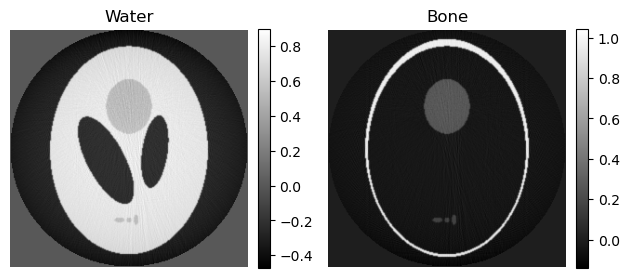

In [61]:
water_estimate = backproject(filter_ramlak(proj_water_estimate/pixel_size), angles)
bone_estimate = backproject(filter_ramlak(proj_bone_estimate/pixel_size), angles)


# show density maps [g/cm^3]
fig, axs = plt.subplots(1, 2)
pcm1 = axs[0].imshow(water_estimate, cmap='gray')
fig.colorbar(pcm1, ax=axs[0], fraction=0.046, pad=0.04)
axs[0].axis('off')
axs[0].title.set_text('Water')
pcm2 = axs[1].imshow(bone_estimate, cmap='gray')
fig.colorbar(pcm2, ax=axs[1], fraction=0.046, pad=0.04)
axs[1].axis('off')
axs[1].title.set_text('Bone')
fig.tight_layout()
plt.show()

## Algebraic Reconstruction
We have quite a big offset from our original images using FBP. Next we will switch to our algebraic reconstruction (ART) algorithm.

In [62]:
# The number of iterations for the ART algorithm    
iters = 10

# Prepare mask and renormalization term (Don't worry about this too much)
mask = get_mask(water.shape)

# The number of image pixels contributing to the respective ray (rot. symmetric)
mask_proj = np.sum(mask, axis=0)

# Norm is one over the number of image pixels. This accounts for division by 0.
renorm = np.zeros(detector_pixel_lenght, dtype=np.float32)
renorm[mask_proj != 0] = 1. / mask_proj[mask_proj != 0]

# Start with an initial guess of zeros for the tomogram or the FBP
initial_tomo = water_estimate.copy()
initial_tomo2 = bone_estimate.copy()

# Initialize
tomo = initial_tomo.copy()
tomo2 = initial_tomo2.copy()
error = []

# Main loop over the iterations
for i in range(iters):
    
    # Forwardproject your tomorgam for the current angle
    proj = forwardproject(tomo, angles)
    proj2 = forwardproject(tomo2, angles)
            
    # Calculate the difference between the forward projection and 
    #the sinogram for the current angle    
    diff = proj_water_estimate/pixel_size - proj
    diff2 = proj_bone_estimate/pixel_size - proj2
        
    # Accumulate the error to the total error
    error.append(np.sum(diff**2))
        
    # Back-project the renormalized difference for the current angle
    # Hint - multiply the difference by renorm calculated above    
    tomo_update = backproject(renorm * diff, angles)
    tomo_update2 = backproject(renorm * diff2, angles)
        
    # Update the tomogram
    tomo += tomo_update
    tomo2 += tomo_update2
    
    print('\rIteration %i completed!'.ljust(80) % (i + 1))
    print('Error: %.2f' % error[-1])

Iteration 1 completed!                                                        
Error: 792519017.64
Iteration 2 completed!                                                        
Error: 2282174.80
Iteration 3 completed!                                                        
Error: 1076396.62
Iteration 4 completed!                                                        
Error: 542773.23
Iteration 5 completed!                                                        
Error: 308358.36
Iteration 6 completed!                                                        
Error: 205130.79
Iteration 7 completed!                                                        
Error: 159450.15
Iteration 8 completed!                                                        
Error: 139028.56
Iteration 9 completed!                                                        
Error: 129712.27
Iteration 10 completed!                                                        
Error: 125297.81


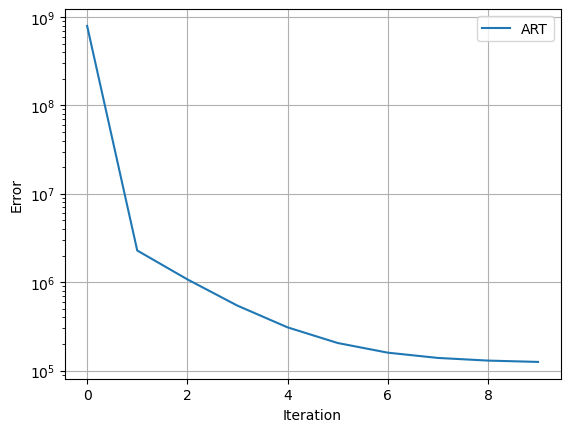

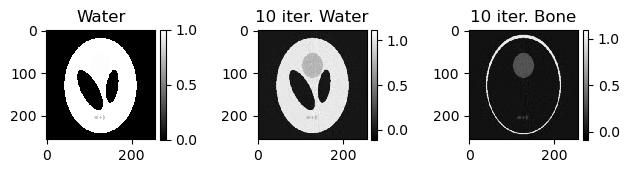

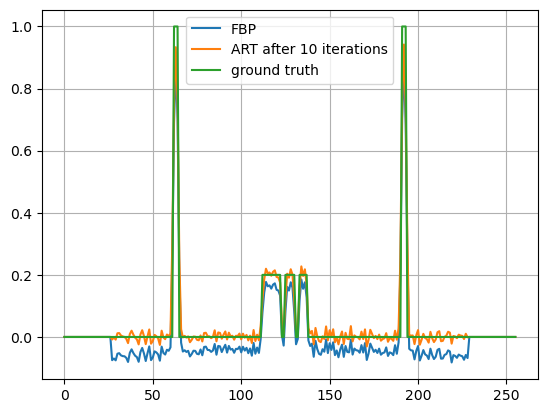

In [63]:
# Plotting some stuff

# Plot the error versus the number of iterations.
plt.figure()
plt.clf()
plt.semilogy(error, label='ART')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.grid(True)
plt.legend()

# Plot your estimate of the tomogram as above for the FBP
plt.figure()
plt.clf()
plt.subplot(1, 3, 1)
plt.title('Water')
plt.imshow(water, cmap='gray', interpolation='none')
plt.colorbar(fraction=0.046, pad=0.04)
#plt.axis('off')
plt.subplot(1, 3, 2)
plt.title('%i iter. Water' % iters)
plt.imshow(tomo, cmap='gray', interpolation='none')
plt.colorbar(fraction=0.046, pad=0.04)
#plt.axis('off')
plt.subplot(1, 3, 3)
plt.title('%i iter. Bone' % iters)
plt.imshow(tomo2, cmap='gray', interpolation='none')
plt.colorbar(fraction=0.046, pad=0.04)
#plt.axis('off')
plt.tight_layout()
plt.savefig('./report_figures/10_art_images.pdf',bbox_inches='tight')

# Prepare a lineplot through the FBP and ART reconstruction of bone and compare it to the Ground Truth
plt.figure()
plt.clf()
#plt.title('Lineplot trough FBP and ART reconstruction')
plt.plot(bone_estimate[205], label='FBP')
plt.plot(tomo2[205], label='ART after %i iterations' % iters)
plt.plot(bone[205], label='ground truth')
plt.grid(True)
plt.legend()
plt.savefig('./report_figures/11_art_lineplot.pdf',bbox_inches='tight')

## Noise properties
Let´s examine the noise properties of our newly generated basis material images.

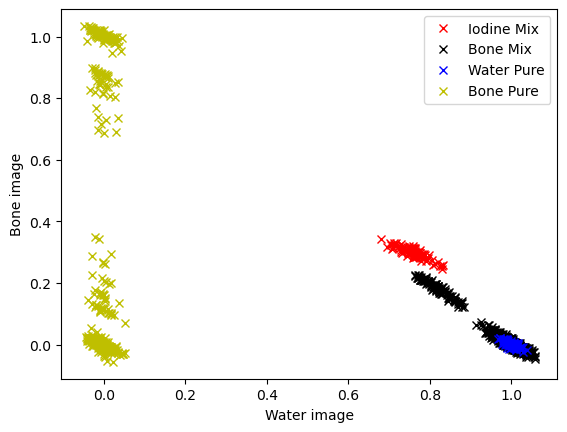

<Figure size 640x480 with 0 Axes>

In [64]:
water_art = tomo
bone_art = tomo2

# ROI = region of interest
roi_iod_water = np.s_[75:85, 125:135]
roi_water = np.s_[200:210, 75:85]
roi_bone_water = np.s_[200:230, 100:150]
roi_bone_pure = np.s_[5:15,100:150]


plt.figure()
#plt.title('Scatter Plot')
plt.plot(water_art[roi_iod_water].flatten()[0], bone_art[roi_iod_water].flatten()[0], 'rx', label = 'Iodine Mix')
plt.plot(water_art[roi_iod_water].flatten(), bone_art[roi_iod_water].flatten(), 'rx')
plt.plot(water_art[roi_bone_water].flatten()[0], bone_art[roi_bone_water].flatten()[0], 'kx', label = 'Bone Mix')
plt.plot(water_art[roi_bone_water].flatten(), bone_art[roi_bone_water].flatten(), 'kx')
plt.plot(water_art[roi_water].flatten()[0], bone_art[roi_water].flatten()[0], 'bx', label = 'Water Pure')
plt.plot(water_art[roi_water].flatten(), bone_art[roi_water].flatten(), 'bx')
plt.plot(water_art[roi_bone_pure].flatten()[0], bone_art[roi_bone_pure].flatten()[0], 'yx', label = 'Bone Pure')
plt.plot(water_art[roi_bone_pure].flatten(), bone_art[roi_bone_pure].flatten(), 'yx')
plt.xlabel('Water image')
plt.ylabel('Bone image')
plt.legend()
plt.show()
plt.savefig('./report_figures/12_anti_correlated_noise.png',bbox_inches='tight')

How would you interpret this image?

## Anti-correlated noise
The Pearson correlation coefficient can be used to summarize the strength of the linear relationship between two data samples.

The Pearson’s correlation coefficient is calculated as the covariance of the two variables divided by the product of the standard deviation of each data sample. It is the normalization of the covariance between the two variables to give an interpretable score.

The coefficient returns a value between -1 and 1 that represents the limits of correlation from a full negative correlation to a full positive correlation. A value of 0 means no correlation. The value must be interpreted, where often a value below -0.5 or above 0.5 indicates a notable correlation, and values below those values suggests a less notable correlation.
  
Pearson's correlation coefficient = covariance(X, Y) / (stdv(X) * stdv(Y))

In [65]:
from scipy.stats import pearsonr

corr, _ = pearsonr(water_art[roi_iod_water].flatten(), bone_art[roi_iod_water].flatten())
print('Pearsons correlation: %.3f' % corr)

cov = np.around(np.cov(water_art[roi_iod_water].flatten(), bone_art[roi_iod_water].flatten())*1E4,1)
print('\n Covariance Matrix *1E4 \n', cov)

Pearsons correlation: -0.867

 Covariance Matrix *1E4 
 [[ 8.7 -4.7]
 [-4.7  3.3]]


## Spectral Maps
Having reconstructed our basis material maps, we can by simple linear transformation switch to different spectral maps. Interesting are e.g. virtual monoenergetic images (MonoEs), iodine density map for the quantification of contrast agent distribution, calcium suppression, virtual no contrast images, $Z_{eff}$ maps, electron density et cetera.  

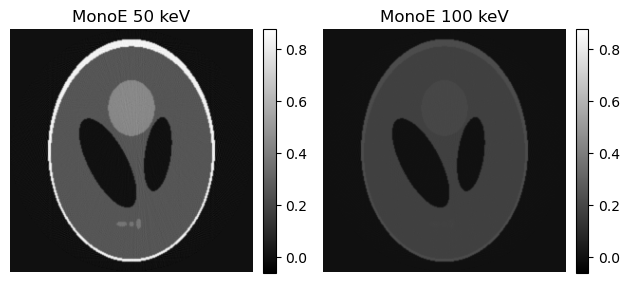

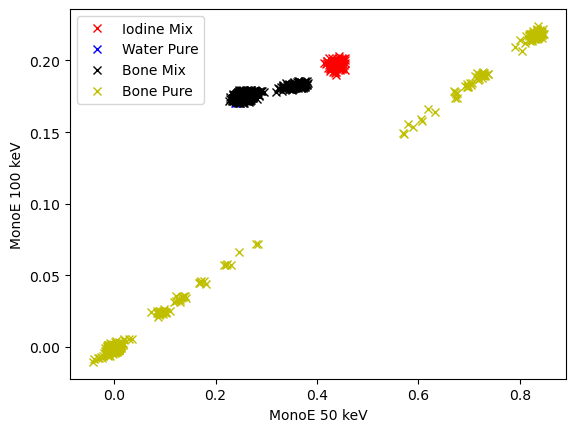

Pearsons correlation: 0.202


In [66]:
# 50 kev equals energy[42] -> we start our energy scale at 8 keV
monoE_50 = water_art*mu_water[42]+bone_art*mu_HA[42]
v_min = monoE_50.min()
v_max = monoE_50.max()
monoE_100 = water_art*mu_water[92]+bone_art*mu_HA[92]

# show MonoEs
fig, axs = plt.subplots(1, 2)
pcm1 = axs[0].imshow(monoE_50, cmap='gray', vmin=v_min, vmax=v_max)
fig.colorbar(pcm1, ax=axs[0], fraction=0.046, pad=0.04)
axs[0].axis('off')
axs[0].title.set_text('MonoE 50 keV')
pcm2 = axs[1].imshow(monoE_100, cmap='gray', vmin=v_min, vmax=v_max)
fig.colorbar(pcm2, ax=axs[1], fraction=0.046, pad=0.04)
axs[1].axis('off')
axs[1].title.set_text('MonoE 100 keV')
fig.tight_layout()
plt.show()

plt.figure()
#plt.title('Scatter Plot MonoE')
plt.plot(monoE_50[roi_iod_water].flatten()[0], monoE_100[roi_iod_water].flatten()[0], 'rx', label = 'Iodine Mix')
plt.plot(monoE_50[roi_iod_water].flatten(), monoE_100[roi_iod_water].flatten(), 'rx')
plt.plot(monoE_50[roi_water].flatten()[0], monoE_100[roi_water].flatten()[0], 'bx', label = 'Water Pure')
plt.plot(monoE_50[roi_water].flatten(), monoE_100[roi_water].flatten(), 'bx')
plt.plot(monoE_50[roi_bone_water].flatten()[0], monoE_100[roi_bone_water].flatten()[0], 'kx', label = 'Bone Mix')
plt.plot(monoE_50[roi_bone_water].flatten(), monoE_100[roi_bone_water].flatten(), 'kx')
plt.plot(monoE_50[roi_bone_pure].flatten()[0], monoE_100[roi_bone_pure].flatten()[0], 'yx', label = 'Bone Pure')
plt.plot(monoE_50[roi_bone_pure].flatten(), monoE_100[roi_bone_pure].flatten(), 'yx')
plt.xlabel('MonoE 50 keV')
plt.ylabel('MonoE 100 keV')
plt.legend()
plt.savefig('./report_figures/13_monoEs.pdf',bbox_inches='tight')
plt.show()

corr, _ = pearsonr(monoE_50[roi_iod_water].flatten(), monoE_100[roi_iod_water].flatten())
print('Pearsons correlation: %.3f' % corr)

## Three material decomposition
We can try to separate our spectral dataset into three different materials. As we have only two linear independent MonoE images, we will need to introduce a third assumption. In our case it is assumed that the volume of a material mixture at a given temperature and pressure equals the sum of the volume of its constituent parts at the same temperature and pressure. 

$\begin{array}{l}
\mu(E_{1})=f_{1} \mu_{1}(E_{1})+f_{2} \mu_{2}(E_{1})+f_{3} \mu_{3}(E_{1}) \\
\mu(E_{2})=f_{1} \mu_{1}(E_{2})+f_{2} \mu_{2}(E_{2})+f_{3} \mu_{3}(E_{2}) \\
f_{1}+f_{2}+f_{3}=1.0
\end{array}$  

Using our iodine volume fraction, we can calculate a virtual no contrast (VNC) image. This can be very useful in clinical practice, as we save the X-ray dose applied to the patient making a native scan.

In [67]:
# densities of basis materials in pure form
rho_water_pure = 1.0 # [g/cm^3]
rho_HA_pure = 1.0 # [g/cm^3]
rho_I_pure = 4.933 # [g/cm^3]
# attenuation coefficients in pure form
mue_1l, mue_1h = np.array([mu_water[42], mu_water[92]])*rho_water_pure # water at 50 and 100 keV (l=low, h=high)
mue_2l, mue_2h = np.array([mu_HA[42], mu_HA[92]])*rho_HA_pure
mue_3l, mue_3h = np.array([mu_I[42], mu_I[92]])*rho_I_pure
# define a 2x2 decomposition matrix by rewriting matrix A and solution vector b
A = np.asarray([[mue_1l - mue_3l, mue_2l - mue_3l],[mue_1h - mue_3h, mue_2h - mue_3h]])
# set empty arrays for volume fractions
rows, cols = np.shape(monoE_50)
f1 = np.zeros((rows, cols)) # water
f2 = np.zeros((rows, cols)) # bone
f3 = np.zeros((rows, cols)) # iodine


for i in range(cols):
    for j in range(rows):
        b = np.asarray([monoE_50[i,j] - mue_3l, monoE_100[i,j] - mue_3h])
        x = np.linalg.solve(A, b)            
        f1[i,j] = x[0]
        f2[i,j] = x[1]
        f3[i,j] = 1 - f1[i,j] - f2[i,j]
   
        #exclude pixel with attenuation coeff. smaller than 0.1 [1/cm] (air)
        if monoE_50[i,j] < 0.1:
            f1[i,j] = f2[i,j] = f3[i,j] = 0
            
# physically negative volume fractions and values above 1.0 make no sense
f1_clipped = np.clip(f1, 0.0, 1.0)
f2_clipped = np.clip(f2, 0.0, 1.0)
f3_clipped = np.clip(f3, 0.0, 1.0)

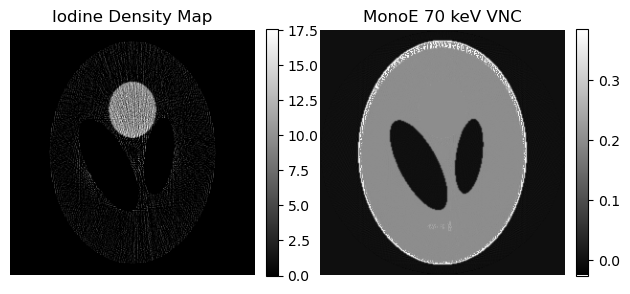

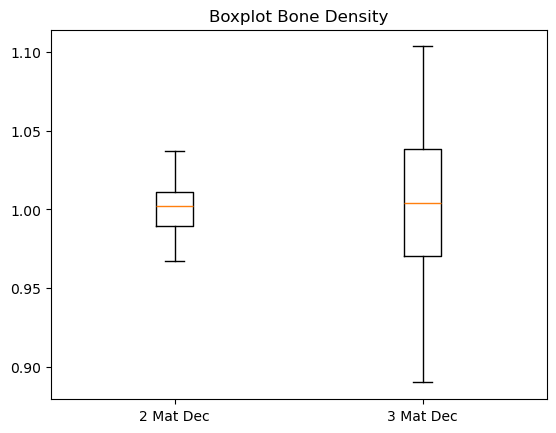

In [68]:
# calculat densities
iod_3mat = f3_clipped*rho_I_pure
# Using our iodine density image we want to calculate a VNC
# for this we need to substract the contribution of iodine attenuation from a e.g. MonoE
monoE_70 = water_art*mu_water[62]+bone_art*mu_HA[62]
monoE_70_VNC =  monoE_70# replace iodine absorption with water equivalent absoption
monoE_70_VNC[f3_clipped > 0.0] = mu_water[62]
        

fig, axs = plt.subplots(1, 2)
pcm1 = axs[0].imshow(iod_3mat*1000, cmap='gray')
fig.colorbar(pcm1, ax=axs[0], fraction=0.046, pad=0.04)
axs[0].axis('off')
axs[0].title.set_text('Iodine Density Map')
pcm2 = axs[1].imshow(monoE_70_VNC, cmap='gray')
fig.colorbar(pcm2, ax=axs[1], fraction=0.046, pad=0.04)
axs[1].axis('off')
axs[1].title.set_text('MonoE 70 keV VNC')
fig.tight_layout()
plt.savefig('./report_figures/15_iodmap_VNC.pdf',bbox_inches='tight')
plt.show()

# using a box plot we want to compare the stability of the 3matdec vs 2matdec
# we will look at water densities
water_3mat = f1*rho_water_pure # we do not use clipped here to conservate the noise for our boxplot
data = [water_art[roi_water].flatten(), water_3mat[roi_water].flatten()]

plt.figure()
plt.title('Boxplot Bone Density')
plt.boxplot(data, labels=['2 Mat Dec','3 Mat Dec'])
plt.show()

## Conventional vs. spectral reconstruction
Here we want to investigate the properties of our conventional reconstruction. For this we simply add the photon counts from our front and rear scintillator layer.

In [69]:
lineintegral_full = -np.log((i_a_front_integrated_noisy + i_a_rear_integrated_noisy)/np.sum(i_0_pix * energy))

sino_filtered = filter_ramlak(lineintegral_full/pixel_size)
fbp = backproject(sino_filtered, angles)

iters = 10
shape = monoE_50.shape

full_art, error = art(iters, shape, detector_pixel_lenght, fbp, angles, lineintegral_full, pixel_size)

Reconstructing: 010 / 1000

Iteration 1 completed!                                                        
Error: 310925957.62
Iteration 2 completed!                                                        
Error: 19657489.29
Iteration 3 completed!                                                        
Error: 11689749.27
Iteration 4 completed!                                                        
Error: 7906709.02
Iteration 5 completed!                                                        
Error: 6014873.76
Iteration 6 completed!                                                        
Error: 4996356.09
Iteration 7 completed!                                                        
Error: 4398559.31
Iteration 8 completed!                                                        
Error: 4016015.57
Iteration 9 completed!                                                        
Error: 3752177.32
Iteration 10 completed!                                                        
Error: 3559295.41


In the following we will compare conventionally reconstructed images with MonoE images reconstructed using our DLCT design. For the MonoE energy we choose an image, so that the attenuation of water from conv. and spectral results are equal.

MonoE  50  keV


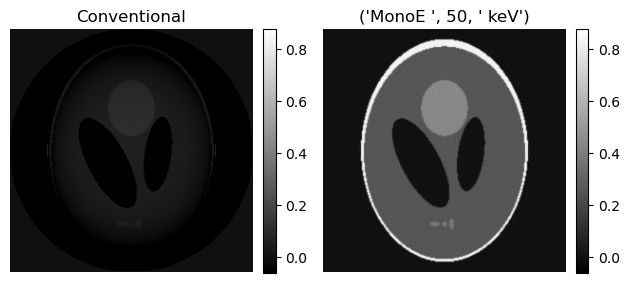

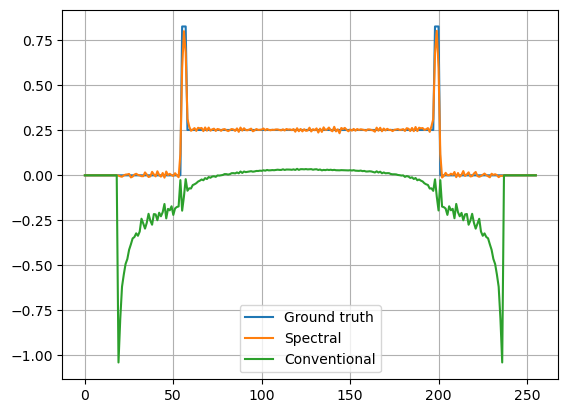

In [70]:
energy_idx = 42
monoE_val = 'MonoE ', energy_idx + 8, ' keV'
print('MonoE ', energy_idx + 8, ' keV') # our energy scale starts at 8 keV

monoE = water_art*mu_water[energy_idx]+bone_art*mu_HA[energy_idx]
monoE_gt = water*mu_water[energy_idx]+bone*mu_HA[energy_idx]+iod*mu_I[energy_idx] # ground truth

v_min = monoE.min()
v_max = monoE.max()

fig, axs = plt.subplots(1, 2)
pcm1 = axs[0].imshow(full_art, cmap='gray', vmin=v_min, vmax=v_max)
fig.colorbar(pcm1, ax=axs[0], fraction=0.046, pad=0.04)
axs[0].axis('off')
axs[0].title.set_text('Conventional')
pcm2 = axs[1].imshow(monoE, cmap='gray', vmin=v_min, vmax=v_max)
fig.colorbar(pcm2, ax=axs[1], fraction=0.046, pad=0.04)
axs[1].axis('off')
axs[1].title.set_text(monoE_val)
fig.tight_layout()
plt.show()

# Prepare a lineplot through conventional and spectral reconstruction and compare it to the Ground Truth
line = 193 # plot through water region
plt.figure()
plt.clf()
#plt.title('Lineplot conventional and spectral ART + ground truth')
plt.plot(monoE_gt[line], label='Ground truth')
plt.plot(monoE[line], label='Spectral')
plt.plot(full_art[line], label='Conventional')
plt.grid(True)
plt.legend()
plt.savefig('./report_figures/16_beam_hardening_lineplot.pdf',bbox_inches='tight')

What do you observe in the line plot? 
## Beam Hardening  
We can check the spectrum before and after the sample.

The mean energy of the X-ray spectrum gets shifted from 53.52 to 71.12 keV


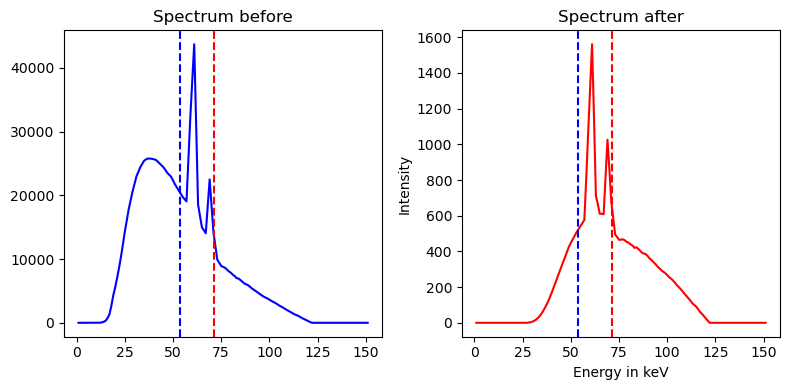

In [71]:
proj = 0
pix = 60
exponent = -mu_water*proj_water[proj,pix]-mu_HA*proj_bone[proj,pix]-mu_I*proj_iod[proj,pix]
# different spectra before and after sample
spec_before = i_0_pix
spec_after = (spec_before*np.exp(exponent)).astype(int)

# mean energy
spec_before_mean = np.sum(spec_before*energy)/np.sum(spec_before)
spec_after_mean = np.sum(spec_after*energy)/np.sum(spec_after)

print('The mean energy of the X-ray spectrum gets shifted from {before} to {after} keV'.format\
      (before=spec_before_mean.round(2), after=spec_after_mean.round(2)))

fig, axs = plt.subplots(1, 2,figsize=(8, 4))
axs[0].plot(energy, spec_before, 'b-')
axs[0].title.set_text('Spectrum before')
axs[1].plot(energy, spec_after, 'r-')
axs[1].title.set_text('Spectrum after')
axs[0].axvline(x=spec_before_mean, ymin=0.0, color="blue", linestyle="--")
axs[0].axvline(x=spec_after_mean, ymin=0.0, color="red", linestyle="--")
axs[1].axvline(x=spec_before_mean, ymin=0.0, color="blue", linestyle="--")
axs[1].axvline(x=spec_after_mean, ymin=0.0, color="red", linestyle="--")
#axs[0].plot([spec_before_mean,spec_before_mean+0.0001],[0,spec_before.max()],'b--')
#axs[1].plot([spec_before_mean,spec_before_mean+0.0001],[0,spec_after.max()],'b--')
#axs[1].plot([spec_after_mean,spec_after_mean+0.0001],[0,spec_after.max()],'r--')
#axs[0].plot([spec_after_mean,spec_after_mean+0.0001],[0,spec_before.max()],'r--')
plt.xlabel('Energy in keV')
plt.ylabel('Intensity')
fig.tight_layout()
plt.show()

## Energy dependent absoption
Let´s check the energy dependent attenuation in the iodine water mixture.

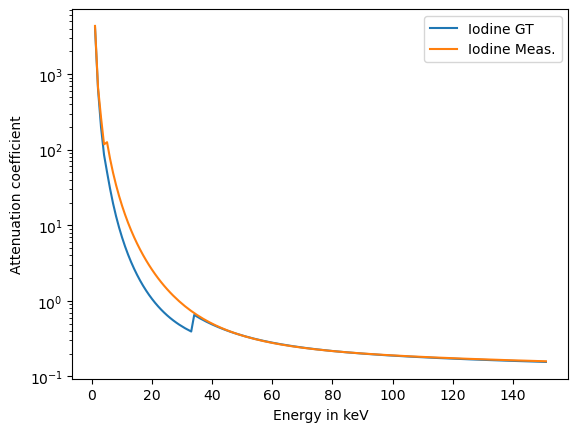

In [72]:
# calculate the energy dependent attenuation of pixels containing water and iod using ground truth values
iod_absoption_gt = mu_water*water[roi_iod_water].mean() + mu_HA*bone[roi_iod_water].mean() + mu_I*iod[roi_iod_water].mean()

# using our two basis material decomposition results
iod_absoption_meas = mu_water*water_art[roi_iod_water].mean() + mu_HA*bone_art[roi_iod_water].mean()

plt.figure()
#plt.title('Attenuation Iodine Water Mix')
plt.plot(energy, iod_absoption_gt, label = 'Iodine GT')
plt.plot(energy, iod_absoption_meas, label = 'Iodine Meas.')
plt.xlabel('Energy in keV')
plt.ylabel('Attenuation coefficient')
plt.yscale('log')
plt.legend()
plt.savefig('./report_figures/17_mat_dec_error.pdf',bbox_inches='tight')
plt.show()

Describe the plot. What happens at the k-edge of iodine? Why do we get the shifted values?

In [73]:
# Quantitativly we can measure the relative deviation from our ground truth
# we will do this for iodine and bone water mixture for values above the k-edge -> energy[43]
bone_absoption_gt = mu_water*water[roi_bone_water].mean() + mu_HA*bone[roi_bone_water].mean()\
                    + mu_I*iod[roi_bone_water].mean()
bone_absoption_meas = mu_water*water_art[roi_bone_water].mean() + mu_HA*bone_art[roi_bone_water].mean()

iod_relative_dev = 100 * np.sum(np.abs(iod_absoption_gt[27:]-iod_absoption_meas[27:]))/np.sum(iod_absoption_gt[27:])
bone_relative_dev = 100 * np.sum(np.abs(bone_absoption_gt[27:]-bone_absoption_meas[27:]))/np.sum(bone_absoption_gt[27:])

print('The relative error for iodine attenuation is {iod} %, for bone {bone} %.'.format\
      (iod=iod_relative_dev.round(2), bone=bone_relative_dev.round(2)))

The relative error for iodine attenuation is 9.67 %, for bone 0.24 %.


## $Z_{eff}$ and $\rho_{el}$

By using the dual energy assumption $\mu(E, Z) = a_{ph}(Z) \cdot f_{ph}(E) + a_c(Z) · f_c(E)$, we can decompose our images in the more physical meaningfull components effective atomic number $Z_{eff}$ and electron density $\rho_{el}$, as $a_{ph} = C \cdot \rho_{el} \cdot Z^{3.8}_{eff}$ and $a_c = \rho_{el}$. Here $C$ is a constant factor, $f_{ph}$ and $f_c$ denote the energy dependencies of photoelectric absorption and Compton scattering, respectively. Thereby, $f_c(E)$ is the Klein-Nishina function. The photo effect’s energy dependence for low Z materials is $1/E^{3.2}$.

In [74]:
def kleinnishina(E): # E in keV
    e = E/511.0
    r_e = 2.8179403227E-13 # classical electron radius
    totalcrosssection = 2*np.pi*(r_e)**2*\
    (((1+e)/e**2)*((2+2*e)/(1+2*e)-np.log(1+2*e)/e)+np.log(1+2*e)/(2*e)-(1+3*e)/(1+2*e)**2)
    return totalcrosssection

def f_ph(E):
    return 1/(E**3.2)

# we want to use MonoE50 and 100 keV for our energy dependencies
f_ph_low = f_ph(50)
f_ph_high = f_ph(100)
f_c_low = kleinnishina(50)
f_c_high = kleinnishina(100)
A = np.asarray([[f_ph_low, f_c_low],[f_ph_high, f_c_high]])

We need to invert the following equation system:  
$\left(\begin{array}{l}\mu\left(E_{1}\right) \\ \mu\left(E_{2}\right)\end{array}\right)=\left(\begin{array}{ll}f_{\mathrm{ph}}\left(E_{1}\right) & f_{\mathrm{c}}\left(E_{1}\right) \\ f_{\mathrm{ph}}\left(E_{2}\right) & f_{\mathrm{c}}\left(E_{2}\right)\end{array}\right) \quad\left(\begin{array}{l}a_{\mathrm{ph}}(\mathrm{Z,\rho_{el}}) \\ a_{\mathrm{c}}(\mathrm{Z})\end{array}\right)$

C:\Users\paula\AppData\Local\Temp\ipykernel_20964\1740450900.py:15: RuntimeWarning: invalid value encountered in power
  Z_eff = (a_ph/(C*rho_el))**(1/3.8) # this operation is numerically unstable


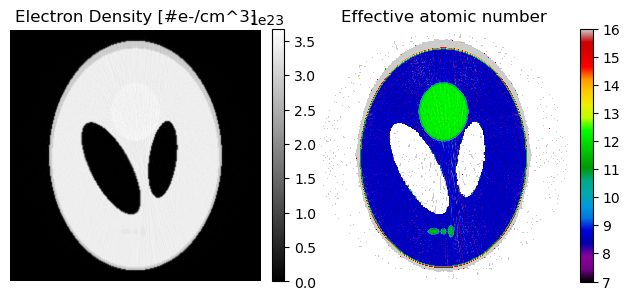

In [75]:
# solve equation system in every pixel
rows, cols = np.shape(monoE_50)[0], np.shape(monoE_50)[1]
a_ph = np.zeros_like(monoE_50)
a_c = np.zeros_like(monoE_50)
for i in range(cols):
    for j in range(rows):
        b = np.asarray([monoE_50[i,j], monoE_100[i,j]])
        x = np.linalg.solve(A, b)
        a_ph[i,j] = x[0]
        a_c[i,j] = x[1]

# from the components we calculate the electron density and Z_eff
C = 1.4e-23 # we set C, so that Z_eff of water is approx. 7.4
rho_el = a_c.clip(1,4e23) # clip to prevent division by 0
Z_eff = (a_ph/(C*rho_el))**(1/3.8) # this operation is numerically unstable
Z_eff[np.where(Z_eff<=1)]=None # air to None
        
# plot images
fig, axs = plt.subplots(1, 2)
pcm1 = axs[0].imshow(rho_el, cmap='gray')
fig.colorbar(pcm1, ax=axs[0], fraction=0.046, pad=0.04)
axs[0].axis('off')
axs[0].title.set_text('Electron Density [#e-/cm^3]')
pcm2 = axs[1].imshow(Z_eff, vmin=7, vmax=16, cmap='nipy_spectral')
fig.colorbar(pcm2, ax=axs[1], fraction=0.046, pad=0.04)
axs[1].axis('off')
axs[1].title.set_text('Effective atomic number')
fig.tight_layout()
plt.savefig('./report_figures/18_zeff_rhoel.pdf',bbox_inches='tight')
plt.show()

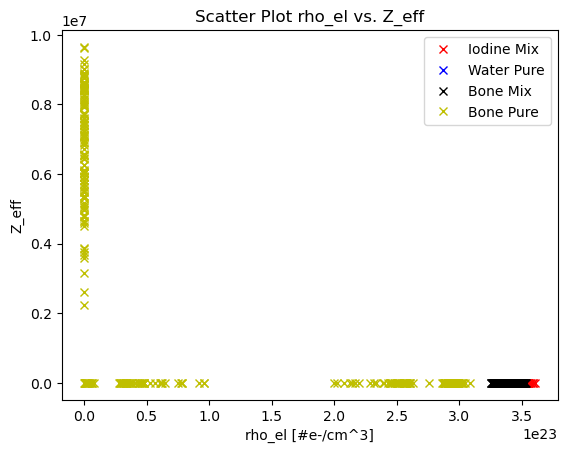

In [76]:
# one more scatter plot
plt.figure()
plt.title('Scatter Plot rho_el vs. Z_eff')
plt.plot(rho_el[roi_iod_water].flatten()[0], Z_eff[roi_iod_water].flatten()[0], 'rx', label = 'Iodine Mix')
plt.plot(rho_el[roi_iod_water].flatten(), Z_eff[roi_iod_water].flatten(), 'rx')
plt.plot(rho_el[roi_water].flatten()[0], Z_eff[roi_water].flatten()[0], 'bx', label = 'Water Pure')
plt.plot(rho_el[roi_water].flatten(), Z_eff[roi_water].flatten(), 'bx')
plt.plot(rho_el[roi_bone_water].flatten()[0], Z_eff[roi_bone_water].flatten()[0], 'kx', label = 'Bone Mix')
plt.plot(rho_el[roi_bone_water].flatten(), Z_eff[roi_bone_water].flatten(), 'kx')
plt.plot(rho_el[roi_bone_pure].flatten()[0], Z_eff[roi_bone_pure].flatten()[0], 'yx', label = 'Bone Pure')
plt.plot(rho_el[roi_bone_pure].flatten(), Z_eff[roi_bone_pure].flatten(), 'yx')
plt.xlabel('rho_el [#e-/cm^3]')
plt.ylabel('Z_eff')
plt.legend()
plt.show()

In [77]:
# We will calculate H2O ground truth electron density
M_water = 18.01528 # g/mol
rho_water = 1.0 # g/ml
N_A = 6.02214076e23 # 1/mol
n_electrons_h2o = 10 # number of electrons in H2O
rho_el_water = N_A/1.801528 # e-/ml
rho_el_deviation = 100*(rho_el[roi_water].mean()-rho_el_water)/rho_el_water # deviation from true value in %
print('The DECT value is off by {dev} % from the theoretically calculated value with {theo} [#e-/cm^3].'\
      .format(dev=rho_el_deviation.round(2), theo=round(rho_el_water, -21)))

The DECT value is off by 2.18 % from the theoretically calculated value with 3.34e+23 [#e-/cm^3].
